# Goal

The goal here is to write everything with modular code and then conduct experiments that allow us to get ECN networks to work properly on the CityScapes dataset. We will try a few different approaches to improve results:

* Try different architectures, including a two-stage approach, as well as trying to predict residuals rather than the original $y$ labels
* Increasing the receptive field size on the input as well as the output


# Setup

In [2]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np
import random

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_miscl, generator

from scripts import *

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Combined`

In [3]:
TRAIN_N = 2975
VAL_N = 500
CLEAN_N = 500

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)

def combined_iterator():
    miscl_generator = generator_miscl.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians, misclassified_frac=0.5)
    f = generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians)
    
    while True:
        if random.random() < (TRAIN_N / (TRAIN_N + CLEAN_N)):
            yield next(miscl_generator)
        else:
            yield next(f)
            
comb = combined_iterator()

# Combined Model

In [5]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None

model_name = "modular_unet_combined_benchmark_other_metrics-100.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

combin_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [6]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=True)

In [7]:
history = combin_model.fit_generator(comb,
                                     steps_per_epoch= (TRAIN_N + CLEAN_N) // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps= VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=4, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/4
500
500
2975
2975

2975
2975

868/868 [==============================] - 302s 348ms/step - loss: 0.3005 - dice_coef: 0.8278 - normalized_iou_coef: 0.5240 - hard_normalized_hard_iou_coef: 0.5845 - val_loss: 0.3273 - val_dice_coef: 0.8213 - val_normalized_iou_coef: 0.5479 - val_hard_normalized_hard_iou_coef: 0.6693
Epoch 2/4
868/868 [==============================] - 295s 339ms/step - loss: 0.2140 - dice_coef: 0.8787 - normalized_iou_coef: 0.5883 - hard_normalized_hard_iou_coef: 0.6518 - val_loss: 0.2545 - val_dice_coef: 0.8434 - val_normalized_iou_coef: 0.5831 - val_hard_normalized_hard_iou_coef: 0.7357
Epoch 3/4
868/868 [==============================] - 296s 341ms/step - loss: 0.1795 - dice_coef: 0.8981 - normalized_iou_coef: 0.6296 - hard_normalized_hard_iou_coef: 0.7106 - val_loss: 0.2234 - val_dice_coef: 0.8866 - val_normalized_iou_coef: 0.6166 - val_hard_normalized_hard_iou_co

In [8]:
history = combin_model.fit_generator(comb,
                                     steps_per_epoch= (TRAIN_N + CLEAN_N) // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps= VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=1, verbose=1)

Epoch 1/1
500
500
868/868 [==============================] - 287s 330ms/step - loss: 0.1537 - dice_coef: 0.9124 - normalized_iou_coef: 0.6475 - hard_normalized_hard_iou_coef: 0.7236 - val_loss: 0.1844 - val_dice_coef: 0.9073 - val_normalized_iou_coef: 0.6734 - val_hard_normalized_hard_iou_coef: 0.8023


2975
2975
2975
2975
0
81871.6211616015 3203.4935350214364 7866.378838896751
0.8808941845798122
1
1116.6264284560457 314.3860679067757 1925.3735711574554
0.3326871241844409
2
36083.06545617664 8482.807264594521 2208.934544324875
0.7714209328897073

0
82793.0 2852.0 6945.0
0.8941894373042445
1
1625.0 12.0 1417.0
0.5320890635232483
2
36632.0 7158.0 1660.0
0.8059845984598459

0
60730.16914397315 3148.328947125119 4850.830856084824
0.8836135907953195
1
13125.18531812355 815.5287858815154 11991.814683675766
0.5061282463266225
2
39045.747046078555 14207.040645034045 1328.2529535889626
0.7153719787105032

0
61584.0 1741.0 3997.0
0.9147678322093817
1
22244.0 245.0 2873.0
0.8770601687564072
2
39857.0 5401.0 517.0
0.8707154560349536

0
58070.888670519926 4499.345653529512 4357.111331343651
0.8676705777265574
1
16193.417220130039 1079.8240844219977 14968.582777321339
0.5022487927174727
2
34943.059057720006 16285.465231746315 2538.9409431815147
0.6498922518761853

0
58659.0 2448.0 3769.0
0.90417103

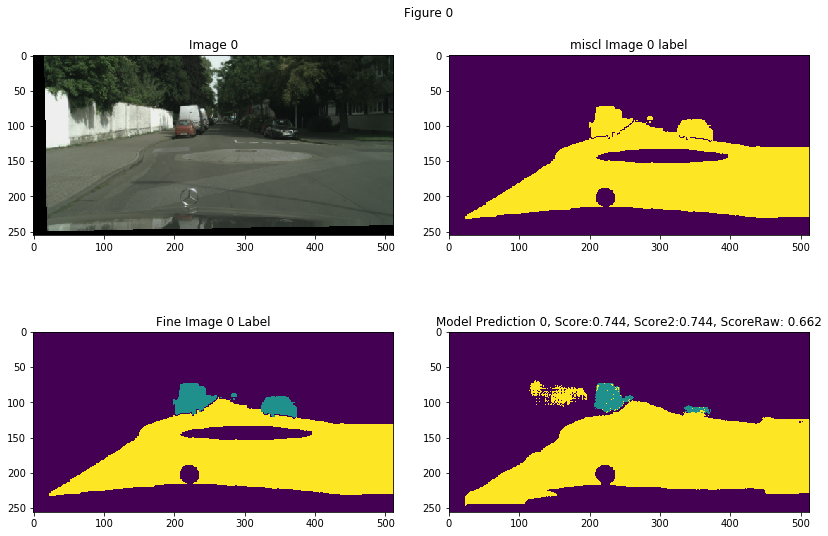

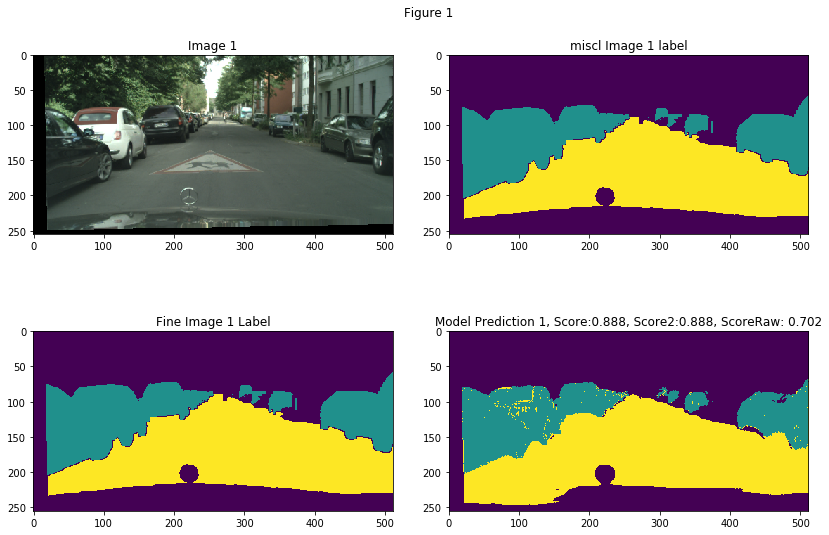

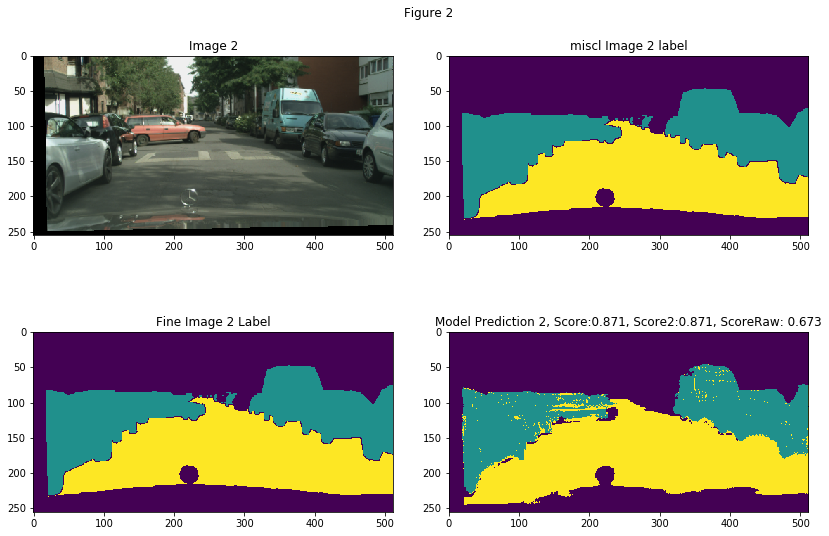

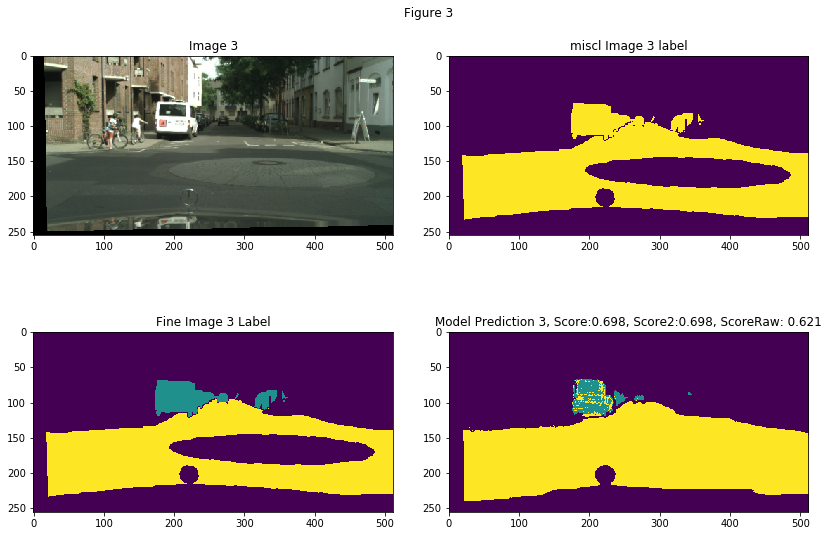

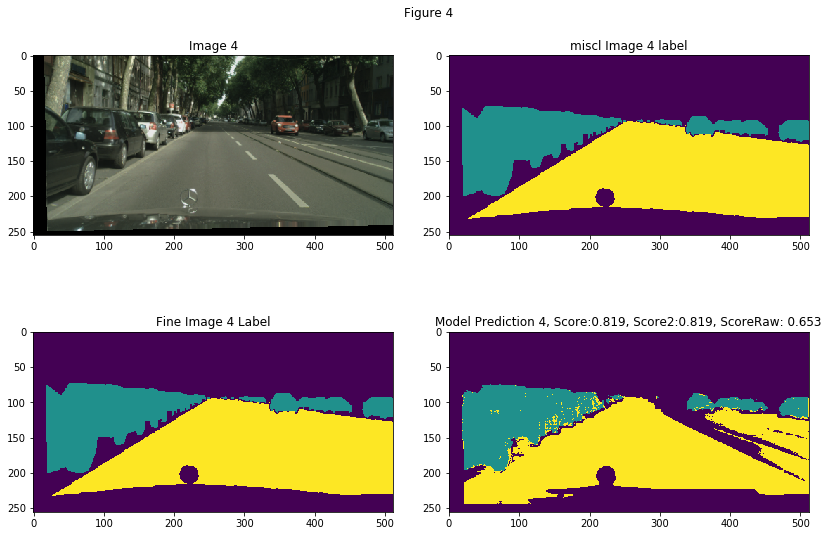

In [9]:
view_paired_predictions_on_training_data(combin_model, ignore_pedestrians=ignore_pedestrians, coarse_or_miscl='miscl')

# Train a Model on Misclassified Data

In [2]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
model_name = "modular_unet_miscl_weights.h5"
TRAIN_N = 2975
VAL_N = 500

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)









Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [3]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True)

In [4]:
miscl_generator = generator_miscl.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians, misclassified_frac=0.5)

In [5]:
history = coarse_model.fit_generator(miscl_generator,
                                     steps_per_epoch= TRAIN_N // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps=VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
5002975
2975

500


743/743 [==============================] - 256s 344ms/step - loss: 0.2984 - dice_coef: 0.8290 - normalized_iou_coef: 0.5142 - hard_normalized_hard_iou_coef: 0.5568 - val_loss: 0.4048 - val_dice_coef: 0.8107 - val_normalized_iou_coef: 0.5284 - val_hard_normalized_hard_iou_coef: 0.5270
Epoch 2/5
743/743 [==============================] - 250s 336ms/step - loss: 0.2133 - dice_coef: 0.8796 - normalized_iou_coef: 0.5802 - hard_normalized_hard_iou_coef: 0.6190 - val_loss: 0.2682 - val_dice_coef: 0.8708 - val_normalized_iou_coef: 0.5861 - val_hard_normalized_hard_iou_coef: 0.5603
Epoch 3/5
743/743 [==============================] - 250s 337ms/step - loss: 0.1921 - dice_coef: 0.8918 - normalized_iou_coef: 0.6018 - hard_normalized_hard_iou_coef: 0.6396 - val_loss: 0.2763 - val_dice_coef: 0.8653 - val_normalized_iou_coef: 0.5894 - val_hard_normalized_hard_iou_coef: 0.6036

# View Predictions

Manually view them to confirm that the predictions on the training set are similar to the training labels

2975
2975
2975
2975
0
81903.9822532814 5035.273824427044 7834.017748057842
0.8642096969643136
1
980.1937874639407 833.6934826019126 2061.8062137961388
0.2529079741587852
2
34317.15515040024 8001.701456377548 3974.8448492884636
0.7412920995951897

0
83607.0 3650.0 6131.0
0.8952649162633315
1
1032.0 22.0 2010.0
0.3368146214099217
2
36017.0 6744.0 2275.0
0.7997379873878675

0
60831.567006293684 7632.938037066022 4749.432995021343
0.830874129109185
1
10130.695755860768 796.8917006014701 14986.30424439907
0.3909368717290754
2
37281.540217863396 14398.367149887375 3092.459781527519
0.6806633008256726

0
61792.0 5631.0 3789.0
0.8677189237768915
1
12944.0 324.0 12173.0
0.5087850320349043
2
38909.0 11472.0 1465.0
0.7504725533310188

0
56610.72175847273 6968.395539962221 5817.278240203857
0.8157588203115359
1
13999.246599971317 1232.2045312136204 17162.753403127193
0.43215281255458005
2
33590.5749589093 18670.856527202974 3891.4250423908234
0.5981988635227984

0
56989.0 3368.0 5439.0
0.866146878

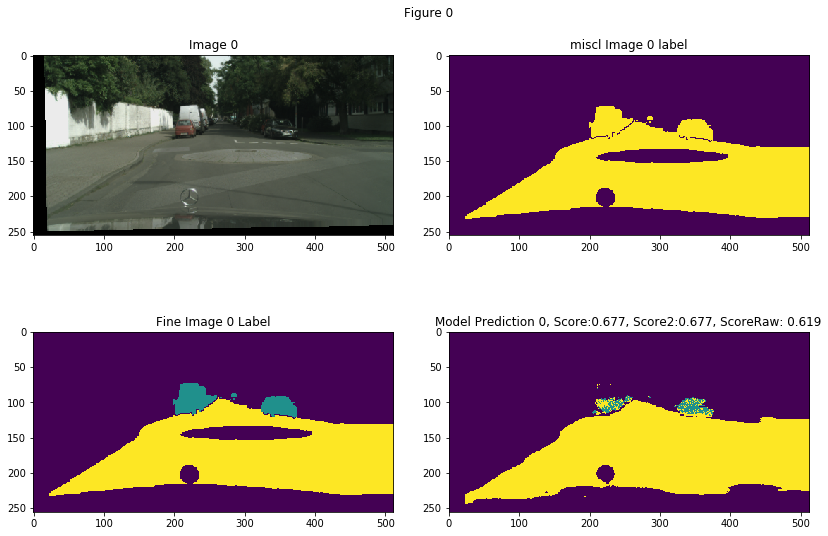

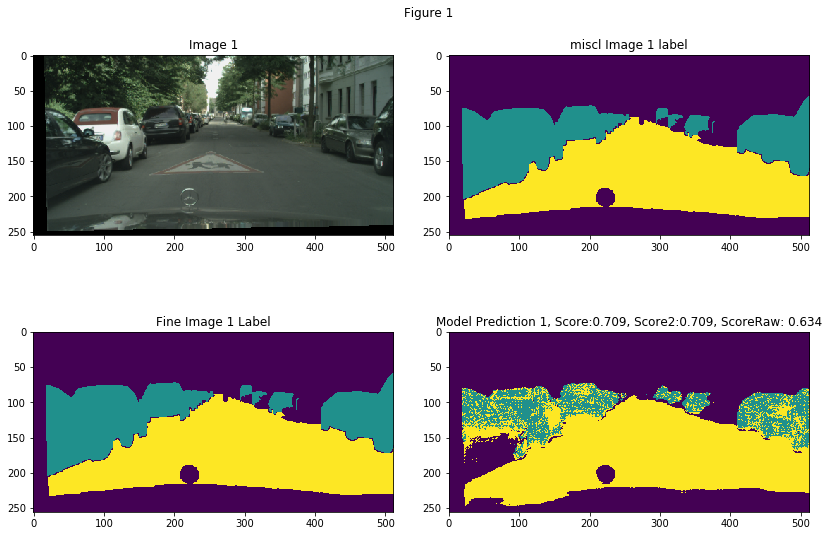

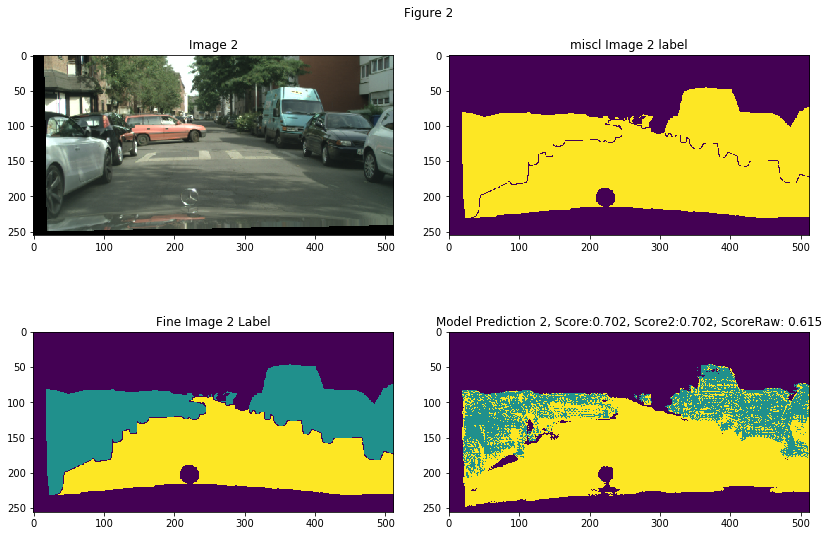

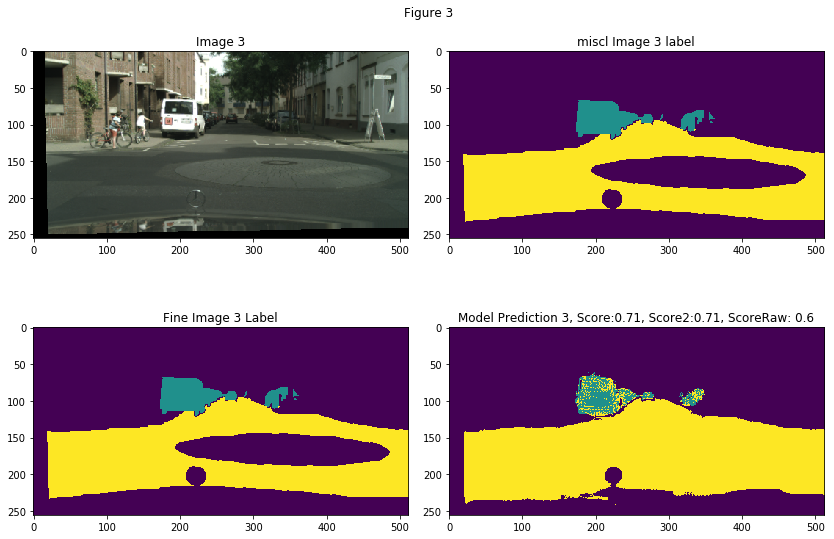

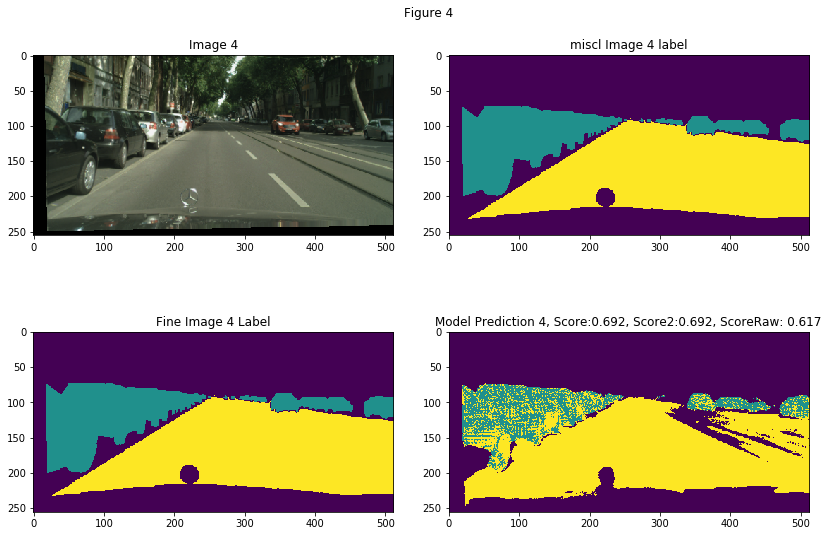

In [6]:
view_paired_predictions_on_training_data(coarse_model, ignore_pedestrians=ignore_pedestrians, coarse_or_miscl='miscl')

# Get Error-Correcting Model

In [7]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D, Lambda
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

input_window_size = 64
output_window_size = 1

# ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

lr_init = 1e-3
lr_decay = 5e-4

inp_y = Input(shape=(input_window_size, input_window_size, 3))
inp_x = Input(shape=(input_window_size, input_window_size, 3))

h = Concatenate()([inp_x, inp_y])
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(40, activation='relu')(h)
h = Dense(3, activation='softmax')(h)
h = Reshape((1, 1, 3))(h)
ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_x, inp_y])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
# h = Flatten()(h)
# h = Dense(40, activation='relu')(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_y, inp_x])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(inp_y)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Flatten()(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=inp_y, outputs=h)

ec_model.summary()
metrics=['mean_squared_error', dice_coef]
ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                 loss='categorical_crossentropy', metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 64, 64, 6)    0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 8)    776         concatenate_5[0][0]              
__________

# Train EC Model 

In [8]:
test_get_ec_batch()

Test 1 passed
Test 2 passed
Test 3 passed


In [9]:
n_epochs = 5
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)
    print('\nEpoch {}, batch {}, Validation metrics (loss, mse, dice): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.064414, 0.2132727, 0.3608035]
1 [0.9027104, 0.17952444, 0.48472342]
2 [0.96015227, 0.18450712, 0.4258433]
3 [0.8821097, 0.1708135, 0.4378329]
4 [0.7310564, 0.13687381, 0.5153646]
5 [0.60512, 0.11225996, 0.61360896]
6 [0.58240145, 0.109830946, 0.65810925]
7 [0.5282461, 0.09584765, 0.7177896]
8 [0.67593247, 0.13079517, 0.63435614]
9 [0.62500405, 0.121351205, 0.647999]
10 [0.48882872, 0.088701114, 0.69594634]
11 [0.5108262, 0.08604882, 0.71027184]
12 [0.4662335, 0.08424843, 0.73008853]
13 [0.60746115, 0.10507354, 0.7261072]
14 [0.4641288, 0.088030785, 0.7535382]
15 [0.50092405, 0.08989839, 0.7829459]
16 [0.4989514, 0.09144674, 0.75779736]
17 [0.3545159, 0.066115394, 0.79089546]
18 [0.46753046, 0.085713714, 0.75999635]
19 [0.5166746, 0.09891835, 0.747391]
20 [0.62299764, 0.11517449, 0.71446264]
21 [0.53482455, 0.10129314, 0.73334223]
22 [0.5945919, 0.11797284, 0.71467334]
23 [0.39771113, 0.073570706, 0.7607539]
24 [0.37270027, 0.07155984, 0.76047766]
25 [0.59557647, 

In [10]:
identity_model = get_identity_model()

In [11]:
val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)

x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=1,
    output_window_size=1, skip=12, diff=False)

500
500


In [12]:
metrics = identity_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
metrics

30272/30272 [==============================] - 2s 50us/step


[0.19809102426744168, 0.03629734740603921, 0.8884810981740408]

# See Corrected Data (X, Y)

2975
2975
2975
2975


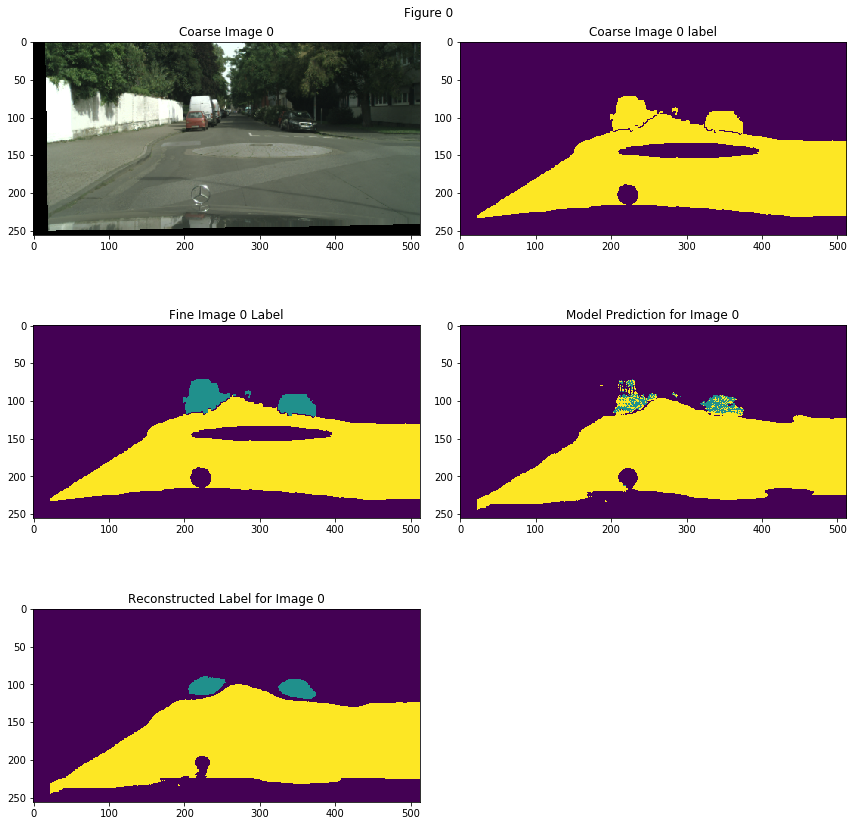

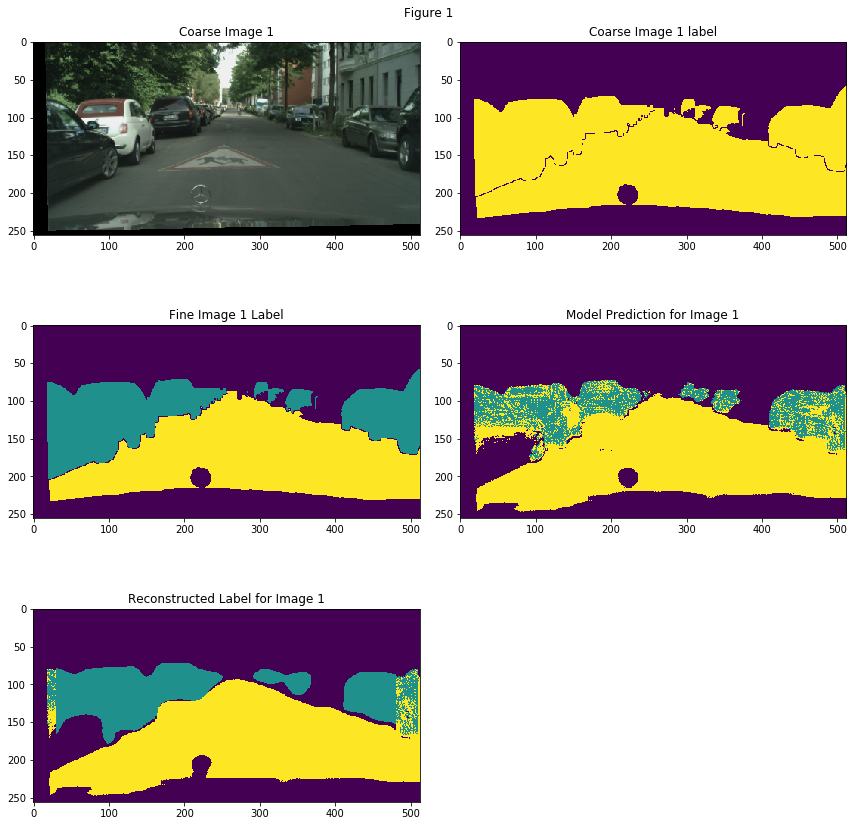

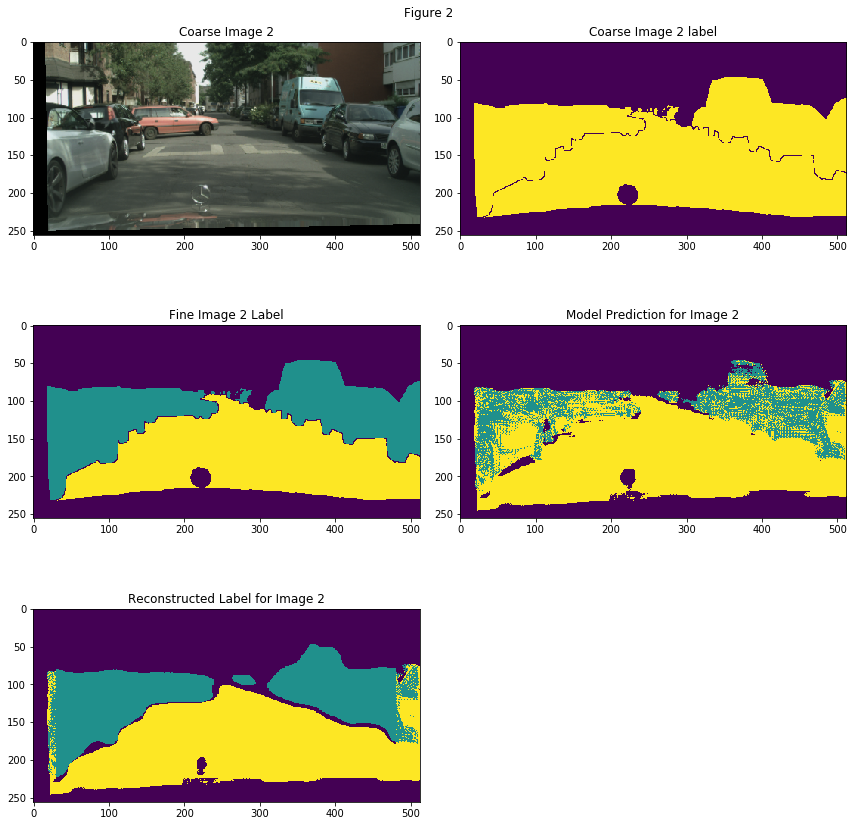

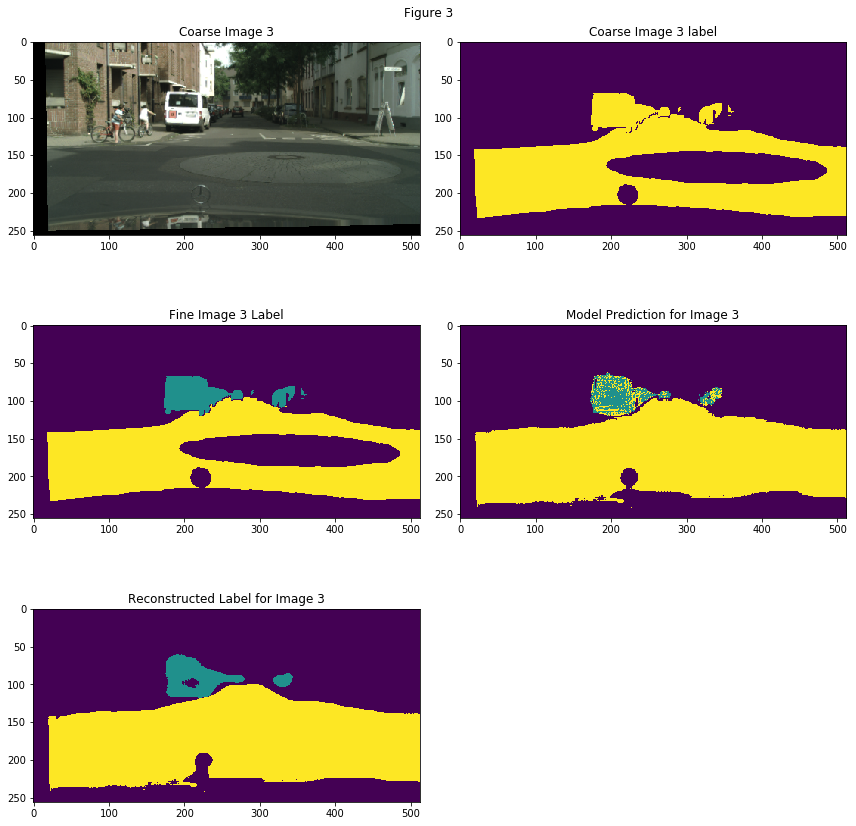

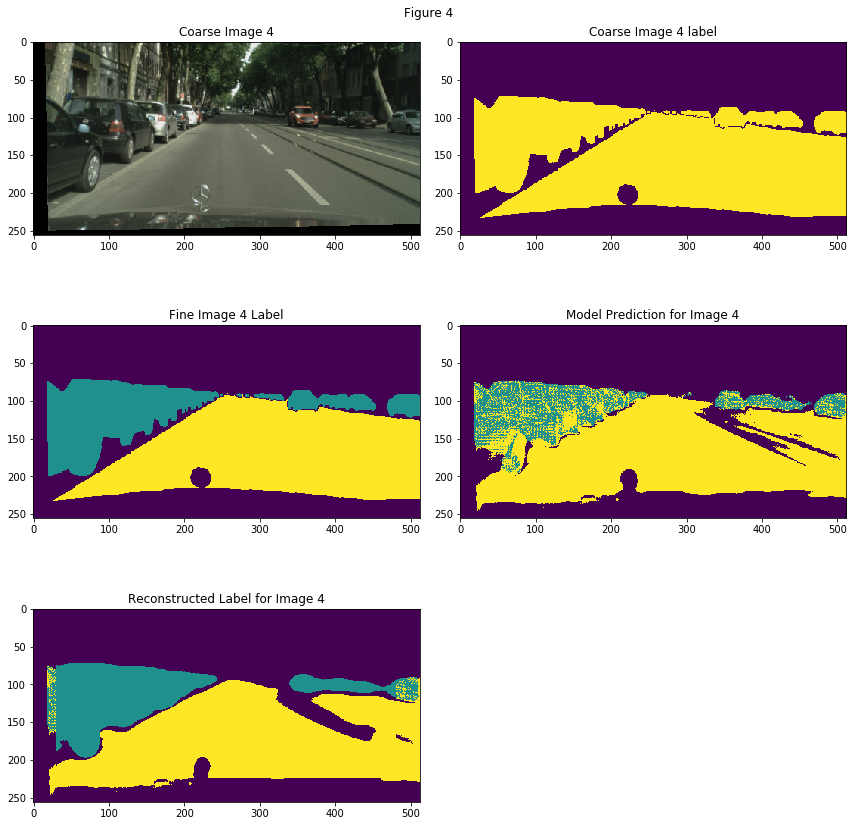

In [13]:
view_corrections_on_training_data(coarse_model, ec_model, n=5, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=True, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True, coarse_or_miscl='miscl')